In [ ]:
# working with files and the operating system
import os               # for file/folder checks, making directories, listing files, path operations
import re               # for regular expressions — useful for cleaning text (remove URLs, extra spaces)

# for reading compressed .bz2 files
import bz2              # to open and decompress .bz2 compressed files (your dataset contains .bz2 files)

# data handling
import pandas as pd     # pandas gives us DataFrame, an easy table-like structure for datasets

# nice progress bars for loops (useful when processing many reviews)
from tqdm.auto import tqdm  # tqdm shows progress bars so you know code is running

# spaCy NLP
import spacy                 # main natural language processing library we'll use
from spacy.matcher import Matcher  # spaCy's pattern matcher for finding custom spans (e.g., brand/product names)


In [ ]:
# STEP 2: Connect Colab to your Kaggle account and download the dataset

# 1️⃣  This lets you upload your personal 'kaggle.json' file from your computer.
#     The 'kaggle.json' file contains your Kaggle username and API key,
#     which Colab uses to access datasets directly from Kaggle.
from google.colab import files
files.upload()   # Click the "Choose File" button that appears and upload kaggle.json

# 2️⃣  Create a hidden folder to store your Kaggle credentials securely.
!mkdir -p ~/.kaggle

# 3️⃣  Copy the uploaded kaggle.json file into that folder.
!cp kaggle.json ~/.kaggle/

# 4️⃣  Change permissions so only you can read the file (for safety).
!chmod 600 ~/.kaggle/kaggle.json

# 5️⃣  Use the Kaggle command-line tool to download the dataset.
#     Here we download the "Amazon Reviews for Sentiment Analysis" dataset
#     created by bittlingmayer. It comes as a .zip file.
!kaggle datasets download -d bittlingmayer/amazonreviews

# 6️⃣  Unzip (extract) the downloaded dataset so we can access its files.
!unzip amazonreviews.zip


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/bittlingmayer/amazonreviews
License(s): unknown
 98% 485M/493M [00:02<00:00, 138MB/s]
100% 493M/493M [00:02<00:00, 219MB/s]
Archive:  amazonreviews.zip
  inflating: test.ft.txt.bz2         
  inflating: train.ft.txt.bz2        


In [ ]:
# STEP 3: Decompress the downloaded Amazon review files (.bz2) so we can read them as normal text

# These files are compressed to save space — they end with ".bz2".
# We'll loop through each of them (train and test) and unzip them.

for fname in ["train.ft.txt.bz2", "test.ft.txt.bz2"]:   # Loop through both training and testing files
    if os.path.exists(fname):                           # Check if the file actually exists in the current folder
        print("Decompressing", fname)

        # Open the compressed file in binary read mode ("rb")
        with bz2.open(fname, "rb") as f_in:
            # Create a new file name without the .bz2 extension, e.g., "train.ft.txt"
            out_name = fname.replace(".bz2", "")

            # Open the new file for writing in binary mode ("wb") and copy the decompressed data
            with open(out_name, "wb") as f_out:
                f_out.write(f_in.read())

        print("Created:", out_name)  # Confirm the new uncompressed file was created
    else:
        # If the file isn't found (maybe already decompressed), just print a message
        print("Not found:", fname)


Decompressing train.ft.txt.bz2
Created: train.ft.txt
Decompressing test.ft.txt.bz2
Created: test.ft.txt


In [ ]:
# STEP 3.5: Peek at the first few lines of the dataset
# ---------------------------------------------
# "!" means we are running a shell command (not Python code) inside Colab.
# "head -n 3" shows the first 3 lines of the file "train.ft.txt"
# "|| true" is there to prevent errors if the file doesn't exist yet.

!head -n 3 train.ft.txt || true


__label__2 Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^
__label__2 The best soundtrack ever to anything.: I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I figured that I'd write a review to disagree a bit. This in my opinino is Yasunori Mitsuda's ultimate masterpiece. The music is timeless and I'm been listening to it for years now and its beauty simply refuses to fade.The price tag on this is pretty staggering I must say, but if you are going to buy any cd for this much money, this is the only one that I feel would be worth every penny.
__label__2 Amazing!: This soundtrack is m

In [ ]:
#import pandas as pd
# pandas = library that makes working with tables of data easy (DataFrame)

# PARAMETERS (adjust)
SAMPLE_SIZE = 20000   # how many reviews to load; change this if you want more/less.
                      # set to None to try to load the whole file (may use lots of memory).
INPUT_FILE = "train.ft.txt"  # the decompressed text file we created earlier

# Read line by line and split label + review
rows = []              # an empty list where we'll store (label, review) pairs

# Open the input file for reading as text.
# encoding="utf-8" helps read normal characters; errors="ignore" skips any weird bytes.
with open(INPUT_FILE, "r", encoding="utf-8", errors="ignore") as f:
    # enumerate(f) gives us (line_number, line_text) for each line in the file
    for i, line in enumerate(f):
        # skip the line if it's empty or only whitespace
        if not line.strip():
            continue

        # Each line begins with a label like "__label__1" followed by a space and the review text.
        # split(" ", 1) splits the string into 2 parts at the first space:
        #   parts[0] = label  (e.g., "__label__2")
        #   parts[1] = review text (the rest of the line)
        parts = line.strip().split(" ", 1)

        # If splitting didn't give us two parts, skip this malformed line
        if len(parts) < 2:
            continue

        # assign the two parts to variables for clarity
        label, review = parts[0], parts[1]

        # add the (label, review) pair to our rows list
        rows.append((label, review))

        # if we've collected SAMPLE_SIZE rows, stop reading more lines
        # (prevents using too much memory during testing)
        if SAMPLE_SIZE and len(rows) >= SAMPLE_SIZE:
            break

# Convert the collected rows into a pandas DataFrame with two columns:
# "raw_label" holds the original label token, "review" holds the text
df = pd.DataFrame(rows, columns=["raw_label", "review"])

# Make the labels human-readable:
# "__label__1" -> "negative", "__label__2" -> "positive"
df["label"] = df["raw_label"].map({"__label__1": "negative", "__label__2": "positive"})

# We no longer need the raw_label column, so drop it for a cleaner table
df = df.drop(columns=["raw_label"])

# Print how many rows we actually loaded (helpful for checking SAMPLE_SIZE)
print("Loaded rows:", len(df))

# Show the first few rows of the DataFrame so we can inspect the data
df.head()


Loaded rows: 20000


,review,label
0,Stuning even for the non-gamer: This sound tra...,positive
1,The best soundtrack ever to anything.: I'm rea...,positive
2,Amazing!: This soundtrack is my favorite music...,positive
3,Excellent Soundtrack: I truly like this soundt...,positive
4,"Remember, Pull Your Jaw Off The Floor After He...",positive


In [ ]:
# STEP 5: Basic cleaning - optional (strip whitespace, fix weird characters)but good practice before doing NLP tasks like entity recognition or sentiment analysis.

# Define a small helper function to clean text
def clean_text(s):
    s = s.strip()                 # remove spaces or line breaks at the start and end of each review
    s = re.sub(r'\s+', ' ', s)    # replace multiple spaces (like 2 or 3 spaces in a row) with just one space
    return s                      # return the cleaned text

# Apply the cleaning function to every review in the "review" column.
# .astype(str) makes sure all data are strings (in case some are numbers or missing values).
df["review"] = df["review"].astype(str).apply(clean_text)

# Show the first few cleaned reviews to confirm the change worked
df.head()


,review,label
0,Stuning even for the non-gamer: This sound tra...,positive
1,The best soundtrack ever to anything.: I'm rea...,positive
2,Amazing!: This soundtrack is my favorite music...,positive
3,Excellent Soundtrack: I truly like this soundt...,positive
4,"Remember, Pull Your Jaw Off The Floor After He...",positive


In [ ]:
# STEP 6: Simple Rule-Based Sentiment Analysis.Not machine lerning yet

# 🟢 List of positive words — words that usually mean a happy or satisfied customer
positive_words = set([
    "love", "amazing", "great", "good", "perfect", "excellent", "best", "awesome", "fantastic",
    "wonderful", "recommend", "satisfied", "works", "fast", "easy", "nice", "friendly", "worth"
])

# 🔴 List of negative words — words that usually mean an unhappy or angry customer
negative_words = set([
    "bad", "poor", "worst", "hate", "awful", "terrible", "disappointed", "disappointing",
    "not worth", "broken", "broke", "problem", "issues", "slow", "refund", "return", "awfully"
])

# Define a simple function that checks if a review sounds positive, negative, or neutral
def get_sentiment_rule(text):
    text_low = text.lower()   # convert the whole text to lowercase so we can compare words easily
    # Count how many positive words appear in the review
    pos = sum(1 for w in positive_words if w in text_low)
    # Count how many negative words appear in the review
    neg = sum(1 for w in negative_words if w in text_low)

    # Decide the overall tone of the review:
    if pos > neg:
        return "Positive"      # more positive words → positive review
    elif neg > pos:
        return "Negative"      # more negative words → negative review
    else:
        return "Neutral"       # if it's balanced or none found → neutral review


In [ ]:
# --- STEP 7: Load spaCy and prepare entity extractor ---

#import spacy
#from spacy.matcher import Matcher   # used to find custom word patterns

# 1️⃣ Load the small English spaCy model
# This model already knows basic English grammar, structure, and entities.
# It can detect things like names (ORG), products, places, etc.
nlp = spacy.load("en_core_web_sm")

# 2️⃣ Create a Matcher object
# The Matcher allows us to define our own rules to find special patterns in text.
# We'll use it to find brand names or product names that spaCy might miss.
matcher = Matcher(nlp.vocab)

# 3️⃣ Define a pattern to find sequences of proper nouns (like "Samsung Galaxy" or "Apple")
# Explanation of pattern parts:
#  - "POS": "PROPN" → look for words that are Proper Nouns (names)
#  - "IS_TITLE": True → the word starts with a capital letter
#  - "OP": "*" → means "zero or more times" (so it can match one or several words)
pattern = [
    {"POS": "PROPN", "IS_TITLE": True},             # first capitalized word
    {"POS": "PROPN", "IS_TITLE": True, "OP": "*"},  # optional extra capitalized words after it
]

# Add the pattern to the matcher and give it a label "PROPN_PRODUCT"
matcher.add("PROPN_PRODUCT", [pattern])


# 4️⃣ Define a function to extract entities and brands from a given spaCy document
def extract_entities_and_brands(doc):
    ent_set = set()  # we use a set to avoid duplicates (e.g., "Apple" showing twice)

    # --- Step A: Extract named entities recognized by spaCy ---
    for ent in doc.ents:
        # Keep only the ones that look like organization or product names
        if ent.label_ in {"ORG", "PRODUCT"}:
            ent_set.add(ent.text)

    # --- Step B: Use our custom matcher to find brand/product patterns manually ---
    matches = matcher(doc)
    for match_id, start, end in matches:
        span = doc[start:end]        # the piece of text that matched our pattern
        text = span.text.strip()     # remove extra spaces around it
        # Filter out results that are too short or too long (to avoid mistakes)
        if len(text) <= 60 and len(text.split()) <= 5:
            ent_set.add(text)

    # Return all unique found entities as a list
    return list(ent_set)


In [ ]:
# --- STEP 8: Apply spaCy to all reviews and collect results ---

#from tqdm.auto import tqdm   # tqdm shows a loading bar to track progress

results = []        # empty list to store our final results for each review
BATCH_SIZE = 2000   # how many reviews to handle at once
                    # (bigger batch = faster, but can use more memory)

# Get all review texts from the DataFrame and store them in a list
texts = df["review"].tolist()

# Loop through the reviews in chunks to avoid memory overload
for i in tqdm(range(0, len(texts), BATCH_SIZE)):   # tqdm adds a progress bar in Colab
    batch = texts[i:i+BATCH_SIZE]   # take a small batch of reviews

    # nlp.pipe() is the fastest way to process multiple texts in spaCy
    # It creates 'Doc' objects for each review, containing tokens, entities, etc.
    for doc in nlp.pipe(batch, batch_size=64):
        # 🏷 Extract product/brand entities using our earlier function
        entities = extract_entities_and_brands(doc)

        # 😀 Get the rule-based sentiment ("Positive", "Negative", or "Neutral")
        sentiment = get_sentiment_rule(doc.text)

        # 📦 Store each review’s results in a dictionary
        results.append({
            "review": doc.text,        # the actual review text
            "entities": entities,      # list of brands/products found
            "sentiment": sentiment     # sentiment label
        })


  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
# --- STEP 9: Display some processed examples ---

#import pandas as pd   # Import pandas for data handling and table display

# 🧩 Convert the list of dictionaries (results) into a DataFrame
# Each dictionary in 'results' becomes one row in the DataFrame
results_df = pd.DataFrame(results)

# ✅ Print the total number of reviews successfully processed
print(f"✅ Processed {len(results_df)} reviews")

# 👀 Display the first 5 rows for a quick preview
# Each row includes: the review text, the extracted entities, and the sentiment
results_df.head()


✅ Processed 20000 reviews


,review,entities,sentiment
0,Stuning even for the non-gamer: This sound tra...,"[Chrono, Cross, Chrono Cross]",Neutral
1,The best soundtrack ever to anything.: I'm rea...,"[Yasunori Mitsuda, Mitsuda, Yasunori]",Positive
2,Amazing!: This soundtrack is my favorite music...,"[Chrono Trigger, Distant, Star, Distant Promis...",Positive
3,Excellent Soundtrack: I truly like this soundt...,"[Fragment, Prayer, Chronopolis, Xander, Unstea...",Positive
4,"Remember, Pull Your Jaw Off The Floor After He...","[Scar, Yasunori, Dreamers, Chrono Cross, Sea, ...",Positive


📊 Sentiment Summary:
sentiment
Positive    11432
Neutral      5635
Negative     2933
Name: count, dtype: int64


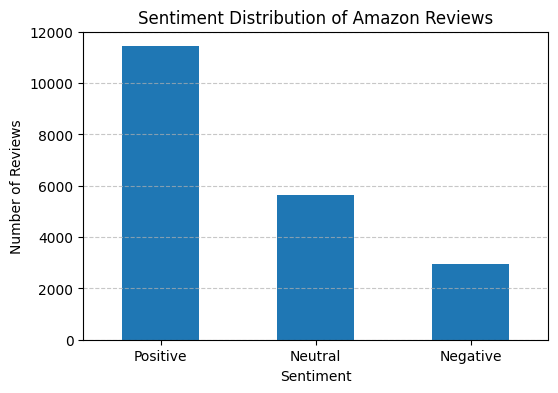

In [ ]:
# --- STEP 10: Summarize and visualize sentiment results ---

import matplotlib.pyplot as plt   # Import the plotting library

# 🧮 Count how many reviews fall into each sentiment category
# Example: Positive = 12000, Negative = 8000, Neutral = 200
sentiment_counts = results_df["sentiment"].value_counts()

# 📰 Print a quick summary of the counts
print("📊 Sentiment Summary:")
print(sentiment_counts)

# 🎨 Create a simple bar chart to visualize the sentiment distribution
plt.figure(figsize=(6,4))                  # Set chart size
sentiment_counts.plot(kind="bar")          # Make a bar chart
plt.title("Sentiment Distribution of Amazon Reviews")  # Add title
plt.xlabel("Sentiment")                    # Label x-axis
plt.ylabel("Number of Reviews")            # Label y-axis
plt.xticks(rotation=0)                     # Keep text horizontal for clarity
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add light horizontal gridlines
plt.show()                                 # Display the chart
